<a href="https://colab.research.google.com/github/7sr7/Intro-to-AI-HW3/blob/main/Silvestre_Intro_to_AI_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Professor Khan, I got an extension to submit this by Saturday (2 August)...

# HW 3: Intro to PyTorch and Neural Nets with MNIST

In this assignment, you'll explore PyTorch fundamentals by implementing a basic **Multi-Layer Perceptron (MLP)** to classify handwritten digits from the **MNIST** dataset.

You will learn:
- How to manipulate tensors
- How to load and batch data with DataLoaders
- How to define and train neural networks in PyTorch
- How to evaluate model performance and visualize results



## Part 1: Exploring Pytorch and building a MLP (15 pts)
In the first part of this homework we'll walk through how to build a basic MLP in pytorch so that you can attempt the other parts with the knowledge you've gained.

## What Are Tensors?

Tensors are the fundamental data structure in PyTorch — they’re like NumPy arrays but with GPU support.

A tensor is:
- A container for numerical data (integers, floats, etc.)
- Able to represent scalars (0D), vectors (1D), matrices (2D), and higher-dimensional arrays (3D+)
- The building block of all neural network operations

In this section, you’ll play around with tensor creation, reshaping, and conversion between NumPy arrays and PyTorch tensors.


In [68]:
import torch
import numpy as np

# Create a tensor from a list
a = torch.tensor([1.0, 2.0, 3.0])
print("Tensor a:", a)

# Create random tensors
x = torch.randn(2, 3)
print("Shape of x:", x.shape)
print("x contents:\n", x)

# Reshape (view)
x_flat = x.view(-1)
print("Flattened x:", x_flat)

# Convert numpy to tensor
arr = np.array([[1, 2], [3, 4]])
tensor_from_np = torch.from_numpy(arr)
print("Tensor from numpy:\n", tensor_from_np)


Tensor a: tensor([1., 2., 3.])
Shape of x: torch.Size([2, 3])
x contents:
 tensor([[-1.4258, -0.7620, -0.4207],
        [ 0.2199,  0.7893,  1.0856]])
Flattened x: tensor([-1.4258, -0.7620, -0.4207,  0.2199,  0.7893,  1.0856])
Tensor from numpy:
 tensor([[1, 2],
        [3, 4]])


## Using the Full MNIST Dataset

So far, you've only interacted with a portion of the MNIST dataset. Now we’ll work with the full dataset.
You’ll use PyTorch's built-in tools to:
- Download and cache the full MNIST dataset
- Apply transformations (normalization)
- Wrap it in a `DataLoader` for batching

This makes it easy to train models without worrying about manual preprocessing or batch management.


In [69]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
# === Load raw MNIST ===
train_raw = MNIST(root="./data", train=True, download=True)
test_raw = MNIST(root="./data", train=False, download=True)

In [70]:
#We do need to normalize our data and convert it from a PIL image to a tensor

In [71]:
train_raw[1]

(<PIL.Image.Image image mode=L size=28x28>, 0)

In [72]:
def normalize(pil_img):
    """Convert PIL image to normalized PyTorch tensor."""
    img = np.array(pil_img, dtype=np.float32) / 255.0     # scale to [0, 1]
    img = (img - 0.1307) / 0.3081                          # normalize
    tensor = torch.tensor(img).unsqueeze(0)               # shape [1, 28, 28], 1=>Grayscale
    return tensor

In [73]:
image_tensor = normalize(train_raw[0][0])
image_tensor.shape

torch.Size([1, 28, 28])

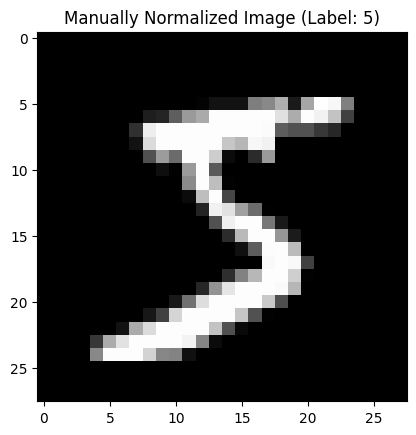

In [74]:
import matplotlib.pyplot as plt

# Convert to numpy for plotting
image_np = image_tensor.squeeze(0).numpy()  # shape: [28, 28]

# Plot using imshow
plt.imshow(image_np, cmap='gray')
plt.title("Manually Normalized Image (Label: {})".format(train_raw[0][1]))

plt.show()


## Understanding `Dataset` and `DataLoader`

In PyTorch, the `Dataset` and `DataLoader` classes are used to organize and efficiently load data for training and evaluation.

### `Dataset`
A `Dataset` object:
- Stores and manages the input data
- Implements two required methods:
  - `__len__()` – returns the number of examples
  - `__getitem__(idx)` – returns a single example (e.g., image and label)

By creating a custom `Dataset`, you have full control over how the data is loaded and preprocessed.

### `DataLoader`
A `DataLoader` takes a `Dataset` and:
- Batches multiple samples together
- Shuffles the data (optional)
- Handles parallel data loading for efficiency

Typical usage:

train_dataset = Dataset(data,other parameters)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [75]:
class MNIST_Dataset(Dataset):
    def __init__(self, raw_data):
        self.data = raw_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        image_tensor = normalize(image)
        return image_tensor, label


In [76]:
train_data = MNIST_Dataset(train_raw)
test_data = MNIST_Dataset(test_raw)

train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)


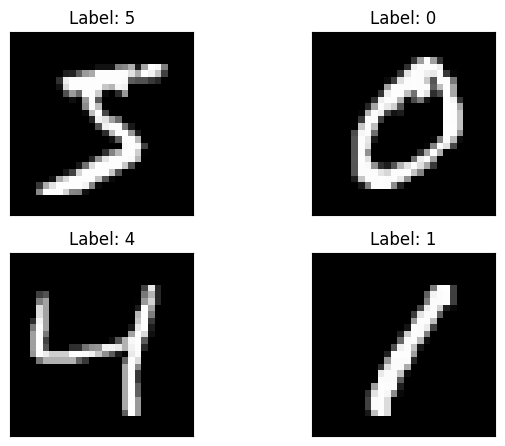

In [77]:
# Iterate through a dataloader
examples = enumerate(train_loader)
batch_idx, (example_data, example_labels) = next(examples)

fig = plt.figure()
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray')
    plt.title(f"Label: {example_labels[i].item()}")
    plt.xticks([])
    plt.yticks([])

In [78]:
#Building our Multi-layer perceptron

In [79]:
import torch.nn as nn
import torch.nn.functional as F

# Define a Multi-Layer Perceptron for MNIST classification
class MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=32,hidden_dim2=11, dropout=0.5):
        super(MLP, self).__init__()
        #Your architecture comes here

        # First fully connected layer: input → hidden
        #fc1= fully connected layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        #dropout is a regularization technique used to prevent overfitting and can be created like
        self.dropout = nn.Dropout(dropout)
        # Second fully connected layer: hidden → hidden
        #These can be the same value, different values, its up to you to find a good architecture
        #You can also try just one hidden, or maybe more than 2, the design is up to you.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        #We just need to be concerned about making sure the dimensions match

        # Final output layer: hidden → 10 output classes (corresponds to digits)
        self.out = nn.Linear(hidden_dim2, 10)

    def forward(self, x):
        #This is where the forward pass occurs with our data
        # B is for Batch
        # Flatten the input image: [B, 1, 28, 28] → [B, 784]
        x = x.flatten(start_dim=1)

        # Pass through first layer + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Pass through second layer + ReLU + Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Final output layer (no softmax; CrossEntropyLoss handles it)
        return self.out(x)


In [80]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


In [81]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy= correct / total
    return total_loss / len(dataloader), accuracy


In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
#For now leave the loss function and optimizer +learning rate as they are.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# We'll track loss and accuracy for each epoch
train_losses = []
val_accuracies = []

# Split training set into train/val by ratio of 50k Train and 10k Val
train_subset, val_subset = torch.utils.data.random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64)

for epoch in range(5):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 1.5298 | Val Accuracy: 0.8596
Epoch 2 | Train Loss: 1.2183 | Val Accuracy: 0.8831
Epoch 3 | Train Loss: 1.1538 | Val Accuracy: 0.8872
Epoch 4 | Train Loss: 1.1284 | Val Accuracy: 0.8900
Epoch 5 | Train Loss: 1.0832 | Val Accuracy: 0.8966


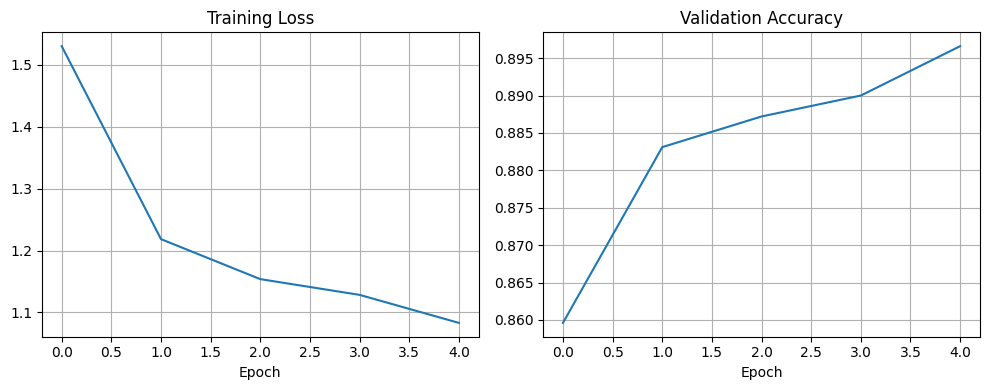

In [83]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()


In [84]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.9012


## Reflection

Answer the following questions in this markdown cell:

1. What part of the training process was most confusing at first?
2. Why do you suppose we use ReLU and dropout in the MLP, what happens if we don't use them?
3. What would happen if we forgot to flatten the image?
4. What modifications, if any, can you make to this architecture to get a testing accuracy higher than 98% and in how many epochs?
5. What is the highest accuracy you can get in 10 epochs.




1 \
Conceptually, I am confident that I understand what actually happens when you are training a NN in both the forward pass and backward pass. However, I was not very familiar with the method names themselves in pytorch and what their explicit purpose were for each step of training a NN. So, the most confusing part was just understanding what each function's purpose was.

2 \
In general, the reason we use NNs instead of regularing ML is because we want to understand nonlinear "patterns" in the data. This is accomplished by the nonlinear activation functions, that of which includes ReLU. Thus, we must use it at each step of our computations (calculating each layer in the forward pass). If we don't use them, we are not finding any nonlinear correlations in the data.
As for dropout, what this does is randomly zero out any given neuron when training on any given batch. The purpose of this is to help prevent overfitting since now any one neuron will not overpower the network.

3 \
If we didn't flatten the image, we would not be able to perform any computations. This is because the dimensions don't match, which are necessary for computing matrix multiplication (weighted sums). In our particular case, we define our input layer size to be 784. Each image has dimensions of 28 x 28. Thus, these dimensions would not match and thus, we would not be able to compute anything.

(4 - 5) work is the code shown below my response...

4 \
I got to ~98% accuracy in 10 epochs by increasing the size of the first 2 hidden layers.
I also implemented another 3rd hidden layer of size 128.


5.
The highest val accuracy that I got in 10 epochs was .9726

#### Modify the following class to have the architecture of your best performing MLP


In [87]:
import torch.nn as nn
import torch.nn.functional as F

# Define a Multi-Layer Perceptron for MNIST classification
class Improved_MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256,hidden_dim2=256, hidden_dim3=128, dropout=0.5):
        super(Improved_MLP, self).__init__()
        #Your architecture comes here

        # First fully connected layer: input → hidden
        #fc1= fully connected layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        #dropout is a regularization technique used to prevent overfitting and can be created like
        self.dropout = nn.Dropout(dropout)
        # Second fully connected layer: hidden → hidden
        #These can be the same value, different values, its up to you to find a good architecture
        #You can also try just one hidden, or maybe more than 2, the design is up to you.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        #We just need to be concerned about making sure the dimensions match

        # Final output layer: hidden → 10 output classes (corresponds to digits)
        self.out = nn.Linear(hidden_dim3, 10)

    def forward(self, x):
        #This is where the forward pass occurs with our data
        # B is for Batch
        # Flatten the input image: [B, 1, 28, 28] → [B, 784]
        x = x.flatten(start_dim=1)

        # Pass through first layer + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Pass through second layer + ReLU + Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))
        x = self.dropout(x)

        # Final output layer (no softmax; CrossEntropyLoss handles it)
        return self.out(x)


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Improved_MLP().to(device)
#For now leave the loss function and optimizer +learning rate as they are.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# We'll track loss and accuracy for each epoch
train_losses = []
val_accuracies = []

# Split training set into train/val by ratio of 50k Train and 10k Val
train_subset, val_subset = torch.utils.data.random_split(train_data, [50000, 10000])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64)

for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.5225 | Val Accuracy: 0.9421
Epoch 2 | Train Loss: 0.2731 | Val Accuracy: 0.9561
Epoch 3 | Train Loss: 0.2340 | Val Accuracy: 0.9613
Epoch 4 | Train Loss: 0.2107 | Val Accuracy: 0.9604
Epoch 5 | Train Loss: 0.1938 | Val Accuracy: 0.9663
Epoch 6 | Train Loss: 0.1809 | Val Accuracy: 0.9698
Epoch 7 | Train Loss: 0.1748 | Val Accuracy: 0.9675
Epoch 8 | Train Loss: 0.1613 | Val Accuracy: 0.9700
Epoch 9 | Train Loss: 0.1577 | Val Accuracy: 0.9732
Epoch 10 | Train Loss: 0.1538 | Val Accuracy: 0.9726


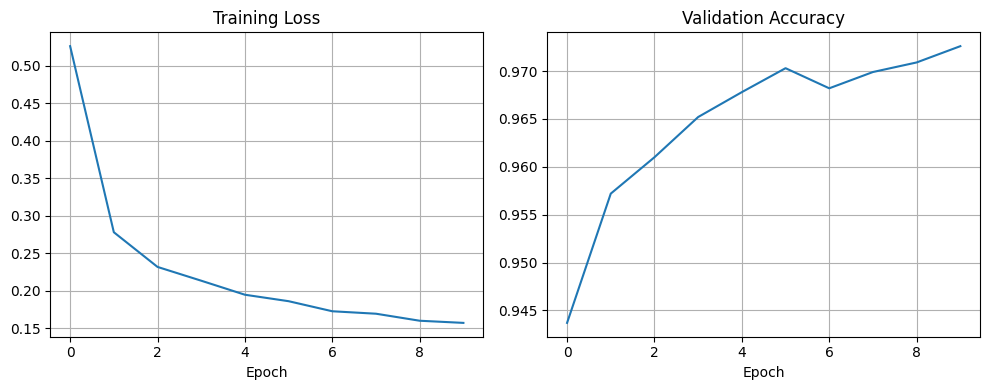

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()


In [89]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.9747


---

# Part 2: CNNs with MNIST (35 pts)



In this part, you will apply your knowledge from part 1 to implement a **Convolutional Neural Network (CNN)** for handwritten digit classification.

You are expected to:
- Define your own CNN model using 2-d Convolutions`nn.Conv2d`
- Train it on the MNIST dataset
- Track and plot training loss and validation accuracy
- Try to reach or exceed **95% validation accuracy**

Feel free to use part 1's code snippets where neccessary, only a skeletal outline has been provided for part 2.


I did a bit of restructuring...

I define the dataset / dataloader and then the train and evaluate loops for my train data and val / test data respectively. This is because these will be constants throughout the variations of my CNN.

I then create 3 different CNNs, where I first make the CNN, train and test it, graph it, and then I repeat this whole process for the other 2 CNNs.

I then summarize everything at the end.

In [19]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import torch

# Load raw MNIST
train_raw = MNIST(root="./data", train=True, download=True)
test_raw = MNIST(root="./data", train=False, download=True)

# Use the custom dataset class from part one to
train_data = MNIST_Dataset(train_raw)
test_data = MNIST_Dataset(test_raw)

# Create train/val/test splits, feel free to use random_split(dataset, [portion1, portion2]) like in part 1
trainSize = int(.9 * len(train_data))
valSize = int(.1 * len(train_data))
train_subset, val_subset = random_split(train_data, [trainSize, valSize])


train_loader = DataLoader(train_subset, batch_size = 64)
val_loader = DataLoader(val_subset, batch_size = 64)
test_loader = DataLoader(test_data, batch_size = 64)


In [25]:
# Write functions to train your model and evaluate it
# You can reuse the functions from Part 1 if needed
# Just modify them for any changes you've made in this part and read the HW_3 Handout if needing an explanation

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return total_loss / len(dataloader), accuracy

### Try atleast 3 different CNN architectures and report their test accuracies here
For example, this is a sample architecture (This does not count towards your 3 but feel free to modify it)
#### CNN-#1
**Conv Layer**
- Input: `[B, 1, 28, 28]`
- Kernel: `Conv2d(1, 8, kernel_size=5, zero padding`
- Output shape after convolution: `[B, 8, 24, 24]`

**Fully Connected Layer**
- Input to linear: `8 × 24 × 24 → 4608 → shape: [B, 4608]`
- Output of linear: `Linear(4608 → 10) → shape: [B, 10]`

---

**Forward Pass Sequence**
1. Start with input tensor: `[B, 1, 28, 28]`
2. Apply `conv1` → output: `[B, 8, 24, 24]`
3. Apply `ReLU` activation
4. Flatten tensor to shape `[B, 4608]`
5. Pass through `fc` layer → output logits: `[B, 10]`

Test Accuracy: 84%

## CNN1...
features:

2 convolution layers
- 32 filters, 64 filters
- dropout: 0.2

2 fc layers
- 128 hidden size, 10 output layers
- dropout: 0.5

max pooling used

RELU activation used (non final fc layer(s))

Epochs used: 10

Test Accuracy:
99.37%

In [48]:
import torch.nn as nn
import torch.nn.functional as F

# Define your own CNN architecture
# Use at least 2 Conv2d layers followed by a fully connected block
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # MNIST images are of the size 1 x 28 x 28, since its grayscale...

        # 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 32, 3, stride = 1, padding=1)

        # 1 x 28 x 28  --> 32 x 14 x 14

        # 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)

        # 32 x 14 x 14 --> 64 x 7 x 7


        # to help with overfitting...
        self.dropout = nn.Dropout(0.5)
        self.conv_dropout = nn.Dropout2d(0.2)

        self.pool = nn.MaxPool2d(2, 2)


        # choosing 128 for my hidden layer size...
        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        # 10 outputs...
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_dropout(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_dropout(x)

        x = x.view(x.size(0), -1)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)

        # no final activation (softmax) since our optimizer will take care of this...
        return x


In [49]:
#Training your CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_accuracies = []

for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.2483 | Val Accuracy: 0.9782
Epoch 2 | Train Loss: 0.1064 | Val Accuracy: 0.9842
Epoch 3 | Train Loss: 0.0782 | Val Accuracy: 0.9862
Epoch 4 | Train Loss: 0.0663 | Val Accuracy: 0.9882
Epoch 5 | Train Loss: 0.0591 | Val Accuracy: 0.9873
Epoch 6 | Train Loss: 0.0526 | Val Accuracy: 0.9885
Epoch 7 | Train Loss: 0.0490 | Val Accuracy: 0.9882
Epoch 8 | Train Loss: 0.0445 | Val Accuracy: 0.9897
Epoch 9 | Train Loss: 0.0414 | Val Accuracy: 0.9902
Epoch 10 | Train Loss: 0.0390 | Val Accuracy: 0.9898


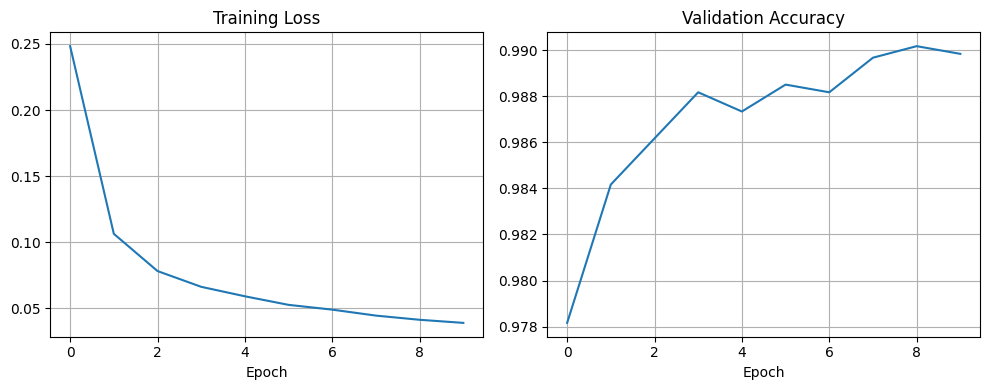

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()


In [51]:
#evaluate your CNN on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9937


## CNN2...
features:

2 convolution layers
- 16 filters, 16 filters
- dropout: 0.2

3 fc layers
- 128, 64 hidden sizes; 10 output layers
- dropout: 0.5

max pooling used

RELU activation used (non final fc layer(s))

Epochs used: 10

Test Accuracy:
98.91%

In [52]:
import torch.nn as nn
import torch.nn.functional as F

# Define your own CNN architecture
# Use at least 2 Conv2d layers followed by a fully connected block
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        # MNIST images are of the size 1 x 28 x 28, since its grayscale...

        # 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 16, 3, stride = 1, padding=1)

        # 1 x 28 x 28  --> 16 x 14 x 14

        # 16 x 14 x 14
        self.conv2 = nn.Conv2d(16, 32, 3, stride = 1, padding=1)

        # 16 x 14 x 14 --> 32 x 7 x 7


        # to help with overfitting...
        self.dropout = nn.Dropout(0.5)
        self.conv_dropout = nn.Dropout2d(0.2)

        self.pool = nn.MaxPool2d(2, 2)


        # choosing 128, 64 for my hidden layer sizes...
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)


        # 10 outputs...
        self.fc3 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_dropout(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_dropout(x)

        x = x.view(x.size(0), -1)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.dropout(x)

        # no final activation (softmax) since our optimizer will take care of this...
        return x


In [53]:
#Training your CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = CNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

train_losses2 = []
val_accuracies2 = []

for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model2, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model2, val_loader, criterion)

    train_losses2.append(train_loss)
    val_accuracies2.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 1.2934 | Val Accuracy: 0.9620
Epoch 2 | Train Loss: 1.0219 | Val Accuracy: 0.9742
Epoch 3 | Train Loss: 0.9887 | Val Accuracy: 0.9762
Epoch 4 | Train Loss: 0.9687 | Val Accuracy: 0.9817
Epoch 5 | Train Loss: 0.9512 | Val Accuracy: 0.9827
Epoch 6 | Train Loss: 0.9373 | Val Accuracy: 0.9820
Epoch 7 | Train Loss: 0.9375 | Val Accuracy: 0.9842
Epoch 8 | Train Loss: 0.9257 | Val Accuracy: 0.9835
Epoch 9 | Train Loss: 0.9208 | Val Accuracy: 0.9840
Epoch 10 | Train Loss: 0.9178 | Val Accuracy: 0.9857


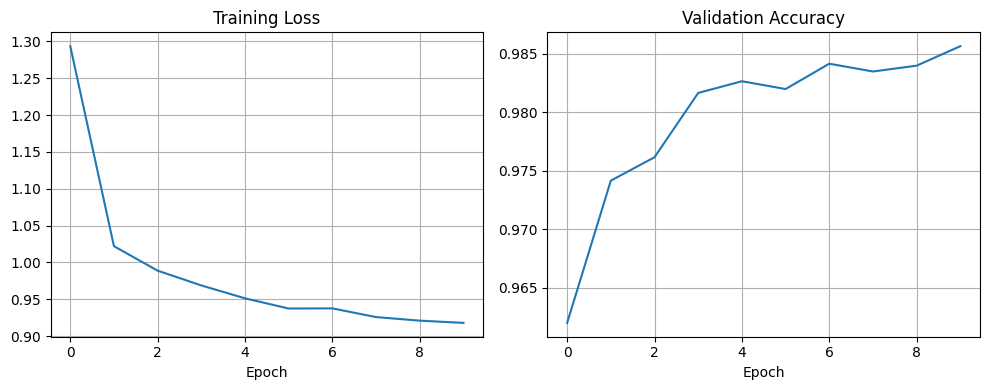

In [54]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()


In [55]:
#evaluate your CNN on test set
test_loss, test_acc = evaluate(model2, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9891


## CNN3...
features:

3 convolution layers
- 32 filters, 64 filters, 64 filters
- dropout: 0.5

3 fc layers
- 128 hidden size, 10 output layers
- dropout: 0.5

max pooling used

RELU activation used (non final fc layer(s))

Epochs used: 10

early stopping used

Test Accuracy:
99.18%

In [59]:
import torch.nn as nn
import torch.nn.functional as F

# Define your own CNN architecture
# Use at least 2 Conv2d layers followed by a fully connected block
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()

        # MNIST images are of the size 1 x 28 x 28, since its grayscale...

        # 1 x 28 x 28
        self.conv1 = nn.Conv2d(1, 32, 3, stride = 1, padding=1)

        # 1 x 28 x 28  --> 32 x 14 x 14

        # 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 1, padding=1)

        # 32 x 14 x 14 --> 64 x 7 x 7

        # 64 x 7 x 7
        self.conv3 = nn.Conv2d(64, 64, 3, stride = 1, padding=1)

        # 64 x 7 x 7 --> 64 x 3 x 3


        # to help with overfitting...
        self.dropout = nn.Dropout(0.5)
        self.conv_dropout = nn.Dropout2d(0.2)

        self.pool = nn.MaxPool2d(2, 2)


        # choosing 128, 64 for my hidden layer sizes...
        self.fc1 = nn.Linear(64 * 3 * 3, 128)

        # 10 outputs...
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_dropout(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_dropout(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_dropout(x)

        x = x.view(x.size(0), -1)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)


        # no final activation (softmax) since our optimizer will take care of this...
        return x


In [60]:
#Training your CNN
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3 = CNN3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

train_losses3 = []
val_accuracies3 = []

# for early stopping...
best_val_acc = float(-1)
best_index = -1
patience = 3
trigger_times = 0
best_model_wts = copy.deepcopy(model3.state_dict())


for epoch in range(10):
    train_loss, train_acc = train_one_epoch(model3, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model3, val_loader, criterion)

    train_losses3.append(train_loss)
    val_accuracies3.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


    # early stopping to prevent overfitting...
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_index = epoch + 1

        # reset...
        trigger_times = 0

    else:
        print("Here...")
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered... loading best weights...")
            break


model.load_state_dict(best_model_wts)
print(f"Best Weights at index {best_index} with a validation accuracy of {best_val_acc}")



Epoch 1 | Train Loss: 0.3182 | Val Accuracy: 0.9807
Epoch 2 | Train Loss: 0.1055 | Val Accuracy: 0.9858
Epoch 3 | Train Loss: 0.0790 | Val Accuracy: 0.9880
Epoch 4 | Train Loss: 0.0687 | Val Accuracy: 0.9883
Epoch 5 | Train Loss: 0.0590 | Val Accuracy: 0.9883
Here...
Epoch 6 | Train Loss: 0.0526 | Val Accuracy: 0.9895
Epoch 7 | Train Loss: 0.0517 | Val Accuracy: 0.9902
Epoch 8 | Train Loss: 0.0472 | Val Accuracy: 0.9900
Here...
Epoch 9 | Train Loss: 0.0432 | Val Accuracy: 0.9902
Here...
Epoch 10 | Train Loss: 0.0402 | Val Accuracy: 0.9908
Best Weights at index 10 with a validation accuracy of 0.9908333333333333


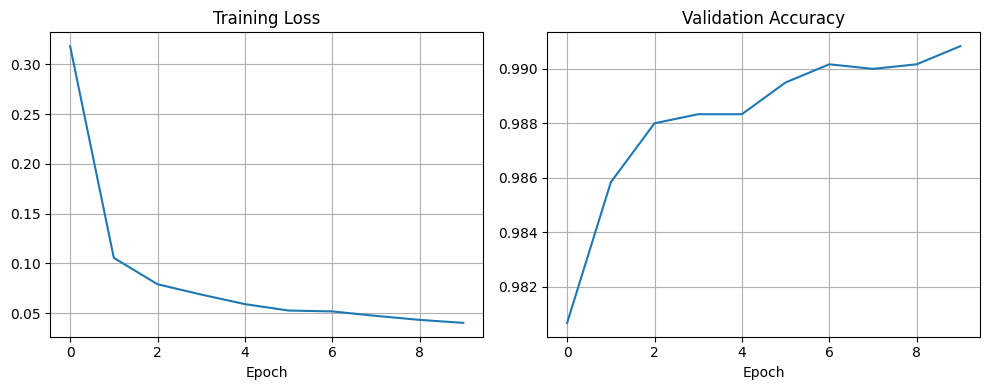

In [61]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses3, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies3, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()


In [62]:
#evaluate your CNN on test set
test_loss, test_acc = evaluate(model3, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9918


---
##After you obtain your highest accuracy on the Test Set

Summarize:
- Your final/Best CNN architecture (list all layers)
- Final validation and test accuracy
- Anything you experimented with (kernel sizes, number of kernels, dropout, etc.)
- Plot the effect of number of epochs on accuracy for your best CNN


CNN1 exhibited the best accuracy on the Test Set.

features:

2 convolution layers
- 32 filters, 64 filters
- dropout: 0.2

2 fc layers
- 128 hidden size, 10 output layers
- dropout: 0.5

max pooling used

RELU activation used (non final fc layer(s))

Final test accuracy: .9941 || Final validation accuracy: .9910

(no early stopping was used, so that i could more precisely graph the effect of number of epochs on accuracy...)


I experimented with number of filters, dropout rate, number of convolution layers, number of fully connected layers, and size of hidden layers in the NN.

In [63]:
#Training your CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_accuracies = []

for epoch in range(30):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1 | Train Loss: 0.2622 | Val Accuracy: 0.9797
Epoch 2 | Train Loss: 0.1000 | Val Accuracy: 0.9833
Epoch 3 | Train Loss: 0.0809 | Val Accuracy: 0.9852
Epoch 4 | Train Loss: 0.0679 | Val Accuracy: 0.9872
Epoch 5 | Train Loss: 0.0603 | Val Accuracy: 0.9872
Epoch 6 | Train Loss: 0.0529 | Val Accuracy: 0.9862
Epoch 7 | Train Loss: 0.0478 | Val Accuracy: 0.9882
Epoch 8 | Train Loss: 0.0455 | Val Accuracy: 0.9890
Epoch 9 | Train Loss: 0.0402 | Val Accuracy: 0.9887
Epoch 10 | Train Loss: 0.0381 | Val Accuracy: 0.9890
Epoch 11 | Train Loss: 0.0370 | Val Accuracy: 0.9885
Epoch 12 | Train Loss: 0.0335 | Val Accuracy: 0.9900
Epoch 13 | Train Loss: 0.0324 | Val Accuracy: 0.9885
Epoch 14 | Train Loss: 0.0310 | Val Accuracy: 0.9902
Epoch 15 | Train Loss: 0.0278 | Val Accuracy: 0.9888
Epoch 16 | Train Loss: 0.0267 | Val Accuracy: 0.9908
Epoch 17 | Train Loss: 0.0264 | Val Accuracy: 0.9897
Epoch 18 | Train Loss: 0.0246 | Val Accuracy: 0.9912
Epoch 19 | Train Loss: 0.0258 | Val Accuracy: 0.9910
Ep

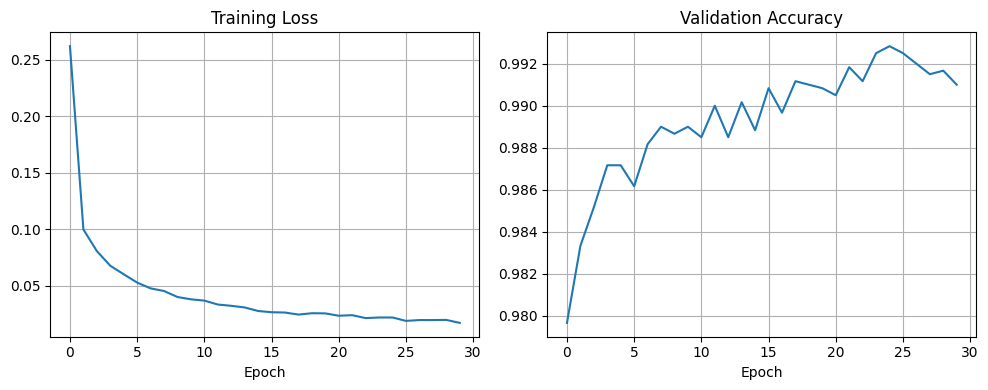

In [64]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.grid()

plt.tight_layout()
plt.show()

In [65]:
#evaluate your CNN on test set
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9941
